Importing libraries and loading the data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.cross_decomposition import PLSRegression
%matplotlib inline
import statsmodels.api as sm

In [2]:
data=sm.datasets.fair.load_pandas().data
data.head() 

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


In [3]:
rate_marriage_ch={
    1.0:"very poor",
    2.0:"poor",
    3.0:"fair",
    4.0:"good",
    5.0:"very good",
}

yrs_married_ch={
    0.5:"less than 1 year",
    2.5:"1-4 years",
    6.0:"5-7 years",
    9.0:"8-10 years",
    13.0:"more than 10 years and oldest child under 12 years of age",
    16.5:"more than 10 years and oldest child between 12 and 17 years of age",
    23.0:"more than 10 years and oldest child more than 18 years of age",
}

religious_ch={
    1.0:"not",
    2.0:"mildly",
    3.0:"fairly",
    4.0:"strongly",
}

education_ch={
    9.0:"grade school", 
    12.0:"high school",
    14.0:"college", 
    16.0:"college graduate", 
    17.0:"graduate school", 
    20.0:"advanced degree"
}

occupation_ch={
    1.0:"student", 
    2.0:"farming, agriculture; semi-skilled, or unskilled worker",
    3.0:"white-colloar",
    4.0:"teacher counselor social worker, nurse; artist, writers; technician, skilled worker", 
    5.0:"managerial, administrative, business", 
    6.0:"professional with advanced degree",   
}

occupation_husb_ch={
    1.0:"student", 
    2.0:"farming, agriculture; semi-skilled, or unskilled worker",
    3.0:"white-colloar",
    4.0:"teacher counselor social worker, nurse; artist, writers; technician, skilled worker", 
    5.0:"managerial, administrative, business", 
    6.0:"professional with advanced degree",   
}

#affairs - unique measurment of time spend in extra-marital affairs: 0.0 - 57.6, calculated as q1*q2/v3, where q1 - with how many different man; 1.0 = 1, 3.5=2-5, 8.0 = 6-10, 12.0 = more than 10; q2 continuing from question above, approximate number of times has sexual relations with each man: 1.0 = 1, 3.5=2-5, 8.0 = 6-10, 12.0 = more than 10, 5.6 = it varied greatly from partner to partner, v3 - number of years married

Data transformation

In [4]:
#Since affairs is a value made up of three different values we just transform it to be 0 if women had no affairs and 1 if woman had any affairs at all, withouth differentiating how much/often 
affairs_ord=[]
for i in data["affairs"]:
    if i > 0:
        affairs_ord.append(1)
    else:
        affairs_ord.append(0)
        
data["affairs_ord"]=affairs_ord

convert_dict={"rate_marriage":"category","yrs_married":"category","religious":"category","educ":"category","occupation":"category","occupation_husb":"category","affairs_ord":"category"}
data = data.astype(convert_dict)

In [5]:
#Checking if the data is balanced - it is clearly not balanced so we need to account for that
num_of_women_with_affair=len(data[data["affairs_ord"]==1])
num_of_women_with_no_affair=len(data[data["affairs_ord"]==0])
print(f"The number of women with affairs is {num_of_women_with_affair} and women with no affair is {num_of_women_with_no_affair}")

The number of women with affairs is 2053 and women with no affair is 4313


In [33]:
#Since the number of women without affair (4313) is more than twice higher that the number of women with no affair (2053), we will randomly choose 2053 women without affair so the data will be more balanced:
affairs=data[data["affairs_ord"]==1]
no_affairs=data[data["affairs_ord"]==0].sample(n=2053)
data_resampling=pd.concat([affairs,no_affairs])
data_resampling

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affairs_ord
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666,1
...,...,...,...,...,...,...,...,...,...,...
3556,4.0,27.0,0.5,2.0,2.0,14.0,3.0,5.0,0.000000,0
6251,4.0,42.0,16.5,4.0,3.0,9.0,2.0,2.0,0.000000,0
2849,4.0,22.0,2.5,0.0,1.0,16.0,4.0,4.0,0.000000,0
4820,5.0,22.0,2.5,0.0,4.0,14.0,3.0,3.0,0.000000,0


Data visualisation

In [7]:
#First we look at the data as a whole, look at histograms, look for simple dependencies
# Women with children are more likely to have an affair than women with no children however,older people longer marriage therefore longer time to have an affair does not factor in at what time point in the marriage the affair happened occupation of husband might affect this as well
# Women who consider themselves as strongly religious (3 and 4) are less likely to have an affair than women with no faith. Way less women are strongly religious approx. 300 (4) compared to non religious women approx 400 (1) 
#etc.

Text(0.5, 1.0, 'Affairs')

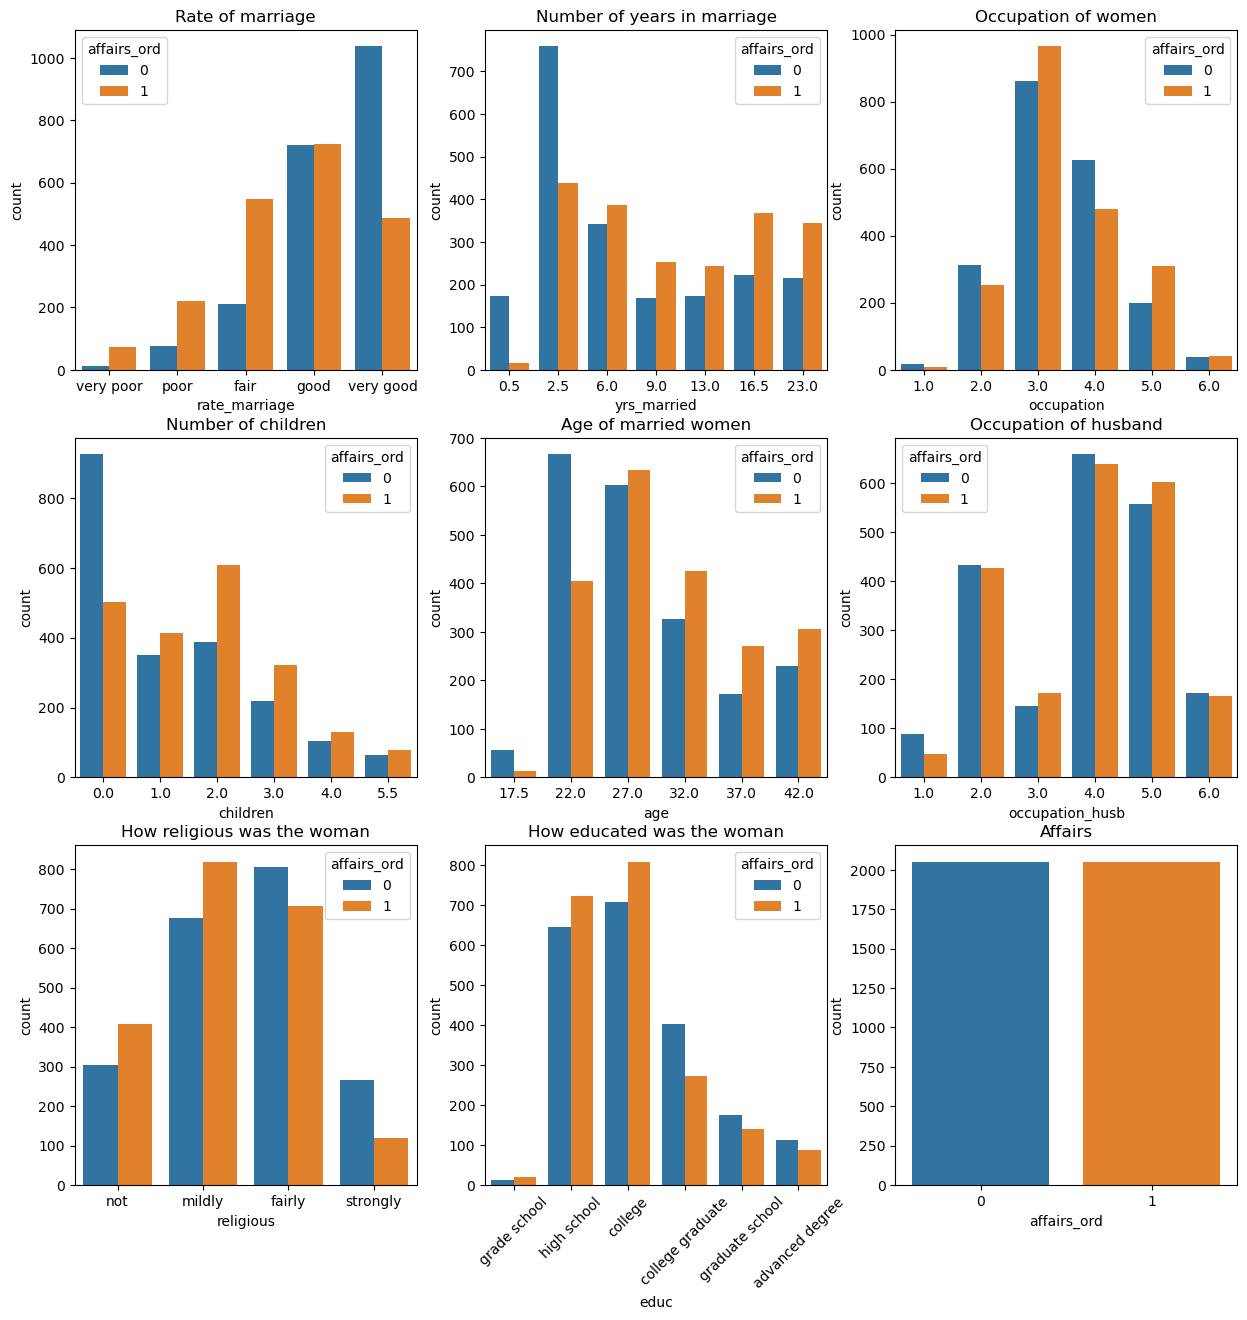

In [8]:
fig,axs=plt.subplots(3,3,figsize=(15, 15))
sns.countplot(data=data_resampling, x="rate_marriage", hue="affairs_ord", ax=axs[0,0]).set(xticklabels=rate_marriage_ch.values(), title="Rate of marriage")
sns.countplot(data=data_resampling, x="children", hue="affairs_ord", ax=axs[1,0]).set_title("Number of children")
sns.countplot(data=data_resampling, x="religious", hue="affairs_ord", ax=axs[2,0]).set(xticklabels=religious_ch.values(), title="How religious was the woman")
sns.countplot(data=data_resampling, x="yrs_married", hue="affairs_ord", ax=axs[0,1]).set_title("Number of years in marriage")
sns.countplot(data=data_resampling, x="age", hue="affairs_ord", ax=axs[1,1]).set_title("Age of married women")
g = sns.countplot(data=data_resampling, x="educ", hue="affairs_ord", ax=axs[2,1])
g.tick_params(axis="x",rotation=45)
g.set(xticklabels=education_ch.values(), title="How educated was the woman")
sns.countplot(data=data_resampling, x="occupation", hue="affairs_ord", ax=axs[0,2]).set_title("Occupation of women")
sns.countplot(data=data_resampling, x="occupation_husb", hue="affairs_ord", ax=axs[1,2]).set_title("Occupation of husband")
sns.countplot(data=data_resampling, x="affairs_ord", ax=axs[2,2]).set_title("Affairs")

C:\Users\nemez\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


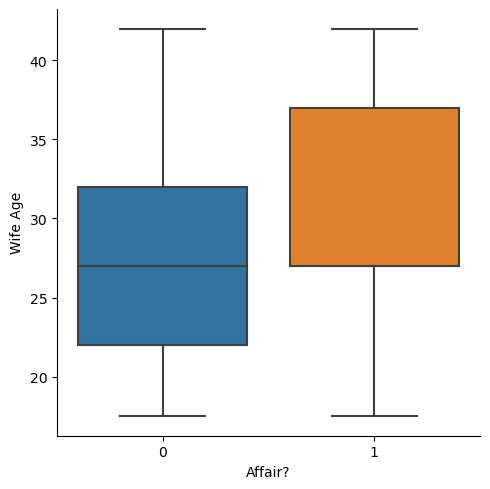

In [9]:
#Then we look at boxplots of two continuos parameters we have: Younger women have fewer instances of affairs than older wives

sns.catplot(
    data=data_resampling,
    x="affairs_ord",
    y="age",
    kind="box",
).set(
    xlabel="Affair?",
    ylabel="Wife Age",
)

C:\Users\nemez\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


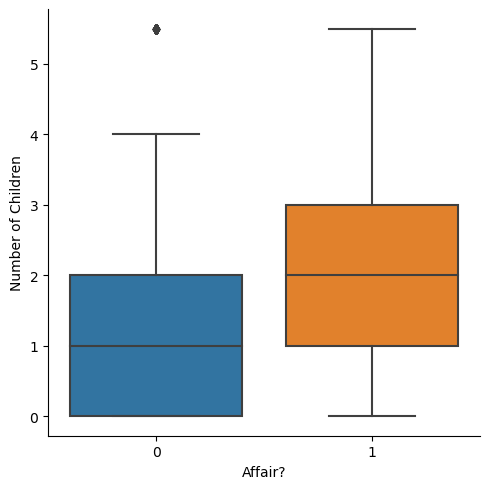

In [10]:
# Women with fewer children have less instances of affairs

sns.catplot(
    data=data_resampling,
    x="affairs_ord",
    y="children",
    kind="box",
).set(
    xlabel="Affair?",
    ylabel="Number of Children",
)

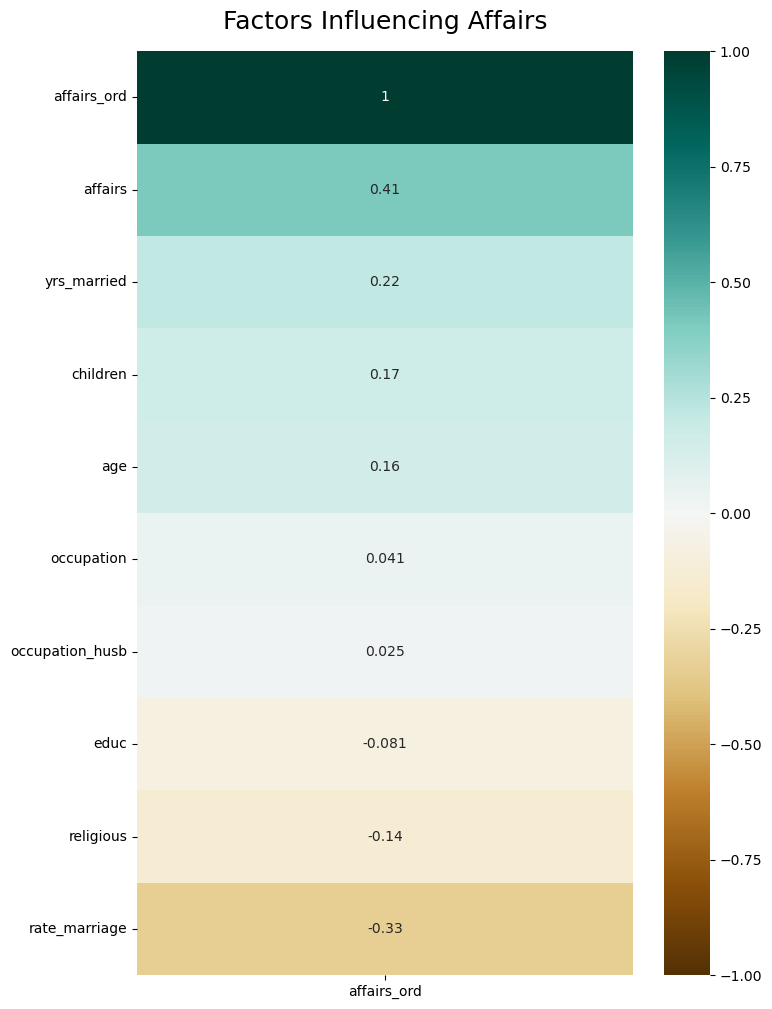

In [11]:
# A Correlation Matrix between Several Parameters Affecting the Occurrence of Affairs
# From this matrix, it shows that the number of years married has the largest influence on affairs, followed by the number of children and the age of the women 
# The rate of marriage and how religious these women are are the least significant factors that influence affairs 
plt.figure(figsize=(8, 12))

heatmap = sns.heatmap(data_resampling.corr()[['affairs_ord']].sort_values(by='affairs_ord', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Factors Influencing Affairs', fontdict={'fontsize':18}, pad=16);

Data division

In [12]:
#Setting which data will be used as a prediciton parameters and which one (affairs_ord) will be a data to predict. Then we split the data to train and test set
X = data_resampling.drop(["affairs","affairs_ord"],axis=1)
y = data_resampling["affairs_ord"]
train_X, test_X, train_y, test_y = train_test_split(X, y)

Models

In [13]:
#We will test five different MI model - Linear Regression, Logistic Regression, K Neighbours, Random Forest and Extra Trees
#We refined each model parameters by changing them and checking the model score.
score=[]
model_LR=LinearRegression(fit_intercept=True).fit(train_X,train_y)
score.append(model_LR.score(test_X, test_y))
model_LogR=LogisticRegressionCV(Cs=10, cv=10, penalty='l2', solver='liblinear',fit_intercept=True).fit(train_X,train_y)
score.append(model_LogR.score(test_X, test_y))
model_KN=KNeighborsClassifier(n_neighbors=5).fit(train_X,train_y)
score.append(model_KN.score(test_X, test_y))
model_RF=RandomForestClassifier(max_depth=4,n_estimators=5).fit(train_X,train_y)
score.append(model_RF.score(test_X, test_y))
model_EF=ExtraTreesClassifier(max_depth=4,n_estimators=100).fit(train_X,train_y)
score.append(model_EF.score(test_X, test_y))

In [14]:
#Table of scores in one place
model=["LinearRegression","LogisticRegression","KNeighborsClassifier","RandomForestClassifier","ExtraTreesClassifier"]
model_score=pd.DataFrame(model).set_axis(["Model_short"],axis="columns")
model_score['Score']=score
model_score

,Model_short,Score
0,LinearRegression,0.147017
1,LogisticRegression,0.676728
2,KNeighborsClassifier,0.608569
3,RandomForestClassifier,0.645570
4,ExtraTreesClassifier,0.665044


In [15]:
#We are not really happy with the result - the models clearly run but, the scores are really low. We decided to refine the models by scaling the data and performing principal ... analysis

Scalling

In [16]:
scaled=pd.DataFrame(StandardScaler().fit(data_resampling.copy()).transform(data_resampling.copy()),columns=data_resampling.columns)

In [17]:
#Converting data from floats to categories
scaled = scaled.astype(convert_dict)

In [18]:
X_s = scaled.drop(["affairs","affairs_ord"],axis=1)
y_s = scaled["affairs_ord"]
train_X_s, test_X_s, train_y_s, test_y_s = train_test_split(X_s, y_s)

In [19]:
score_s=[]
model_LR_s=LinearRegression(fit_intercept=True).fit(train_X_s,train_y_s)
score_s.append(model_LR_s.score(test_X_s, test_y_s))
model_LogR_s=LogisticRegressionCV(Cs=10, cv=10, penalty='l2', solver='liblinear',fit_intercept=True).fit(train_X_s,train_y_s)
score_s.append(model_LogR_s.score(test_X_s, test_y_s))
model_KN_s=KNeighborsClassifier(n_neighbors=5).fit(train_X_s,train_y_s)
score_s.append(model_KN_s.score(test_X_s, test_y_s))
model_RF_s=RandomForestClassifier(max_depth=4,n_estimators=5).fit(train_X_s,train_y_s)
score_s.append(model_RF_s.score(test_X_s, test_y_s))
model_EF_s=ExtraTreesClassifier(max_depth=4,n_estimators=100).fit(train_X_s,train_y_s)
score_s.append(model_EF_s.score(test_X_s, test_y_s))

In [20]:
model_score['Score_scaled']=score_s
model_score

,Model_short,Score,Score_scaled
0,LinearRegression,0.147017,0.169040
1,LogisticRegression,0.676728,0.673807
2,KNeighborsClassifier,0.608569,0.627069
3,RandomForestClassifier,0.645570,0.681597
4,ExtraTreesClassifier,0.665044,0.682571


PCA

In [21]:
X_pca=pd.DataFrame(PCA(n_components=4).fit_transform(scaled.copy().drop(["affairs","affairs_ord"],axis=1)))
y_pca = scaled.copy()["affairs_ord"]

In [22]:
train_X_pca, test_X_pca, train_y_pca, test_y_pca = train_test_split(X_pca, y_pca)

In [23]:
score_pca=[]
model_LR_pca=LinearRegression(fit_intercept=True).fit(train_X_pca,train_y_pca)
score_pca.append(model_LR_pca.score(test_X_pca, test_y_pca))
model_LogR_pca=LogisticRegressionCV(Cs=10, cv=10, penalty='l2', solver='liblinear',fit_intercept=True).fit(train_X_pca,train_y_pca)
score_pca.append(model_LogR_pca.score(test_X_pca, test_y_pca))
model_KN_pca=KNeighborsClassifier(n_neighbors=5).fit(train_X_pca,train_y_pca)
score_pca.append(model_KN_pca.score(test_X_pca, test_y_pca))
model_RF_pca=RandomForestClassifier(max_depth=4,n_estimators=5,random_state=0).fit(train_X_pca,train_y_pca)
score_pca.append(model_RF_pca.score(test_X_pca, test_y_pca))
model_EF_pca=ExtraTreesClassifier(max_depth=4,n_estimators=100,random_state=0).fit(train_X_pca,train_y_pca)
score_pca.append(model_EF_pca.score(test_X_pca, test_y_pca))

In [24]:
model_score['Score_PCA']=score_pca
model_score

,Model_short,Score,Score_scaled,Score_PCA
0,LinearRegression,0.147017,0.169040,0.178207
1,LogisticRegression,0.676728,0.673807,0.678676
2,KNeighborsClassifier,0.608569,0.627069,0.629017
3,RandomForestClassifier,0.645570,0.681597,0.670886
4,ExtraTreesClassifier,0.665044,0.682571,0.672833


Pipelines

In [25]:
score_pip=[]
#Linear Regression
LR = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        PCA(),
        LinearRegression(fit_intercept=True)
),
    {
        "pca__n_components":range(1,5),
    }
)
LR.fit(train_X, train_y)
score_pip.append(LR.score(test_X, test_y))

In [26]:
score_pip=[]
#Linear Regression
LR = make_pipeline(
    StandardScaler(),
    PCA(n_components=4),
    LinearRegression(fit_intercept=True)
)
LR.fit(train_X, train_y)
score_pip.append(LR.score(test_X, test_y))
sum(LR["pca"].explained_variance_ratio_)

0.7683569704026539

In [27]:
#Logistic Regression
LogR = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        PCA(),
        LogisticRegressionCV(Cs=10, cv=10, penalty='l2', solver='liblinear',fit_intercept=True)
),
    {
        "pca__n_components":range(1,5),
    }
)
LogR.fit(train_X, train_y)
score_pip.append(LogR.score(test_X, test_y))

In [28]:
#KNeighbors Classifier
KN = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        PCA(),
        KNeighborsClassifier(n_neighbors=5)
),
    {
        "pca__n_components":range(1,5),
    }
)
KN.fit(train_X, train_y)
score_pip.append(KN.score(test_X, test_y))

In [29]:
#RandomForest Classifier
RF = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        PCA(),
        RandomForestClassifier(max_depth=4,n_estimators=5,random_state=0)
),
    {
        "pca__n_components":range(1,5),
    }
)
RF.fit(train_X, train_y)
score_pip.append(RF.score(test_X, test_y))

In [30]:
#ExtraTrees Classifier
EF = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        PCA(),
        ExtraTreesClassifier(n_estimators=100,random_state=0)
),
    {
        "pca__n_components":range(1,5),
        "extratreesclassifier__max_depth":range(5,10),
    }
)
EF.fit(train_X, train_y)
score_pip.append(EF.score(test_X, test_y))

In [31]:
model_score['Score_Pipelines']=score_pip
model_score

,Model_short,Score,Score_scaled,Score_PCA,Score_Pipelines
0,LinearRegression,0.147017,0.169040,0.178207,0.143644
1,LogisticRegression,0.676728,0.673807,0.678676,0.674781
2,KNeighborsClassifier,0.608569,0.627069,0.629017,0.623174
3,RandomForestClassifier,0.645570,0.681597,0.670886,0.665044
4,ExtraTreesClassifier,0.665044,0.682571,0.672833,0.676728
